# Aim of project

## - To make a model to predict the stage of Alzheimers using Convolutional Neural Networks

Data is available at https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images


About the data directory.
The MRI Images have already been converted to .jpg in the dataset
Dataset consists of two files - Training and Testing both containing a total of around ~5000 images each segregated into the severity of Alzheimer's

Classes:

1. MildDemented
2. VeryMildDemented
3. NonDemented 
4. ModerateDemeneted



In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D, ReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

In [4]:
# checking tensorflow version 
print(tf.__version__)

2.3.0


## Checking data type

The data is stored as

- Alzheimers_s Dataset/
                     test/
                          MildDemented/
                          VeryMildDemented/
                          NonDemented/
                          ModerateDemeneted/
                      train/
                          MildDemented/
                          VeryMildDemented/
                          NonDemented/
                          ModerateDemeneted/  

In [5]:
main_data_file_path = '/Users/Susheel/Desktop/BIOF399_final_project/Alzheimer_s Dataset/'
train_data_file_path = main_data_file_path + 'train/'
test_data_file_path = main_data_file_path + 'test/'

In [7]:
## Parameters

In [6]:
BATCH_SIZE = 32
IMAGE_SIZE = [176, 208]

In [7]:
### getting the dataset ready

In [8]:
train_dataset  = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_data_file_path,
    image_size = IMAGE_SIZE,
    seed = 1000,
    subset = 'training',
    batch_size = BATCH_SIZE,
    validation_split = 0.2)

validataion_dataset  = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_data_file_path,
    image_size = IMAGE_SIZE,
    seed = 1000,
    subset = 'training',
    batch_size = BATCH_SIZE,
    validation_split = 0.2)

test_dataset  = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_data_file_path,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE)

Found 5122 files belonging to 4 classes.
Using 4098 files for training.
Found 5122 files belonging to 4 classes.
Using 4098 files for training.
Found 1279 files belonging to 4 classes.


#### Defining the data classes

In [9]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_dataset.class_names = class_names
validataion_dataset.class_names = class_names

NUM_CLASSES = len(class_names)

## Data visualization

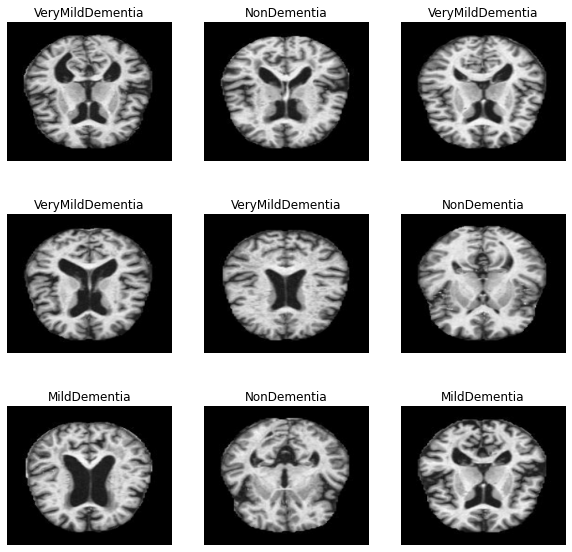

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_dataset.class_names[labels[i]])
    plt.axis("off")
    
plt.savefig('Example_data_type.png')

# Feature Engineering

Because we are working with categorical and noncontinuous data, we want to convert our model into one-hot encodings. One-hot encodings are a way for the model to understand that we're looking at categorial instead of continuous data. Transforming features so that they'll be more understandable is called feature engineering.

In [10]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_dataset = train_dataset.map(one_hot_label)
validataion_dataset = validataion_dataset.map(one_hot_label)
test_dataset = test_dataset.map(one_hot_label)


# Model Building

In [11]:
def build_model():
    
    '''Sequential Model creation'''
    model = Sequential()
    
    model.add(Conv2D(16,(3,3),padding='same',input_shape = (IMAGE_SIZE[0],IMAGE_SIZE[1],3),activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
    
    model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
    
    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
      
    model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
        
    model.add(Flatten())
    model.add(Dense(32))
    model.add(ReLU())
    model.add(Dropout(0.25)) # Avoid over-fitting
    model.add(Dense(4))
    model.add(Activation('softmax'))
    
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 176, 208, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 176, 208, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 104, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 88, 104, 32)       4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 88, 104, 32)       128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 44, 52, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 52, 64)        1

In [16]:
# saving the model summary to a text file
from contextlib import redirect_stdout

with open('modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

In [17]:
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),  
           tf.keras.metrics.AUC(name='auc')]

## Hyperparameters

In [18]:
num_epochs = 10
initial_learning_rate = 0.001
# optimizer is ADAM
opt = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate, name='Adam')

In [19]:
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=METRICS)

## Defining callbacks

In [20]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

# Model fitting

In [21]:
history = model.fit(train_dataset,
                    validation_data=validataion_dataset,
                    callbacks=[checkpoint_cb, early_stopping_cb],
                    epochs= num_epochs
                   )

Epoch 1/10
129/129 [==============================] - 151s 1s/step - loss: 1.4330 - accuracy: 0.7534 - precision: 0.5135 - recall: 0.2557 - auc: 0.7544 - val_loss: 0.9853 - val_accuracy: 0.7953 - val_precision: 0.7127 - val_recall: 0.3038 - val_auc: 0.8142
Epoch 2/10
129/129 [==============================] - 148s 1s/step - loss: 0.9891 - accuracy: 0.7862 - precision: 0.6398 - recall: 0.3316 - auc: 0.8088 - val_loss: 0.9576 - val_accuracy: 0.7762 - val_precision: 0.5645 - val_recall: 0.4583 - val_auc: 0.8258
Epoch 3/10
129/129 [==============================] - 158s 1s/step - loss: 0.9426 - accuracy: 0.7915 - precision: 0.6613 - recall: 0.3402 - auc: 0.8223 - val_loss: 0.8696 - val_accuracy: 0.7981 - val_precision: 0.6469 - val_recall: 0.4239 - val_auc: 0.8431
Epoch 4/10
129/129 [==============================] - 184s 1s/step - loss: 0.8926 - accuracy: 0.7976 - precision: 0.6800 - recall: 0.3599 - auc: 0.8407 - val_loss: 0.8242 - val_accuracy: 0.8087 - val_precision: 0.7137 - val_recal

## Model Visualization

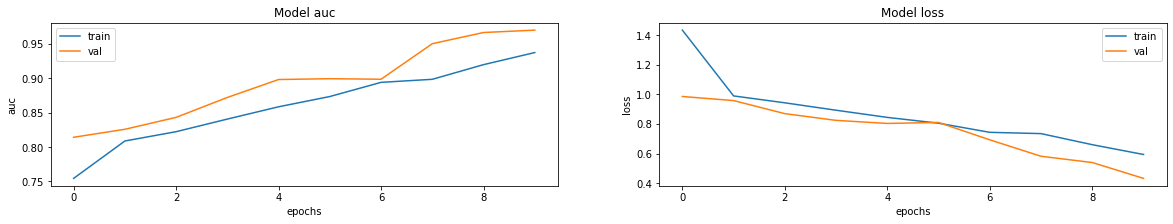

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
plt.savefig("Model_Results.png")    

## Evaluate the Model

In [23]:
scores = model.evaluate(test_dataset)

40/40 [==============================] - 8s 192ms/step - loss: 1.4601 - accuracy: 0.7961 - precision: 0.5974 - recall: 0.5661 - auc: 0.8329


In [26]:
%%capture cap 
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])


In [28]:
# saving the scores to a file
with open('modelscores_on_test_dataset.txt', 'w') as f:
    f.write(cap.stdout)
del cap

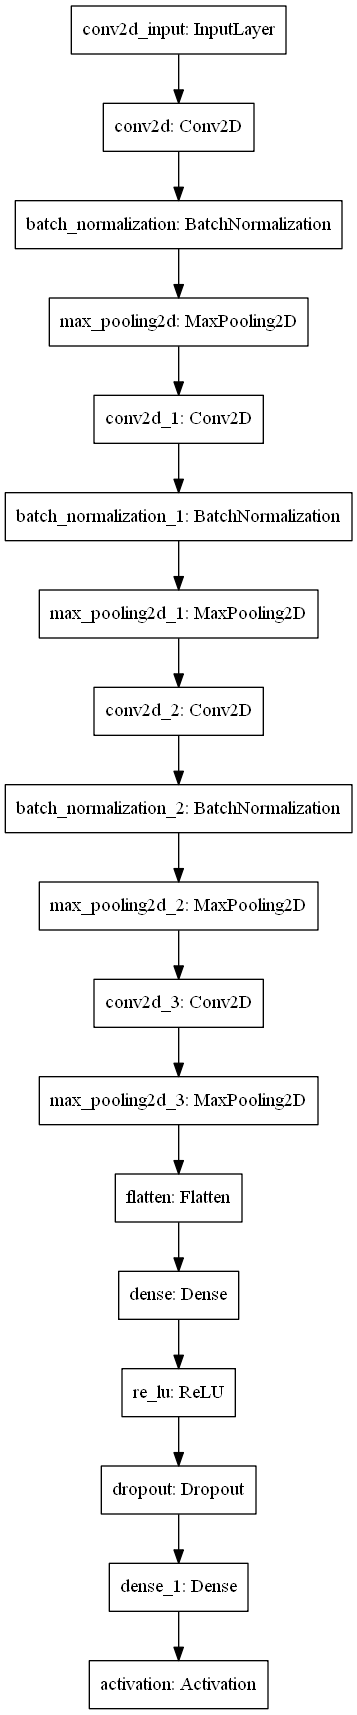

In [13]:
# Plot the model as a figure
tf.keras.utils.plot_model(model, to_file='model.png')